This notebook involves the extraction of the intersection between authors and members of the Shakespeare and Company lending library.

Necessary libraries are imported:

In [49]:
import matplotlib.pyplot as plt # for plotting
import pandas as pd # for data manipulation
from matplotlib_venn import venn2 # for venn diagram

Next, the `books` and `members` datasets from Princeton University's Shakespeare and Company Project are loaded. The `books` dataset contains information about the books in the library of Shakespeare and Company. The `members` dataset contains information about the members of the library.

In [50]:
books = pd.read_csv('../data/raw/SCoData_books_v1.2_2022_01.csv',
                    encoding='utf-8',
                    dtype={'year': 'Int32'})

members = pd.read_csv(
    '../data/raw/SCoData_members_v1.2_2022_01.csv',
    encoding='utf-8',
    dtype={'birth_year': 'Int32', 'death_year': 'Int32'}
)

In [51]:
print(books.columns)

Index(['uri', 'title', 'author', 'editor', 'translator', 'introduction',
       'illustrator', 'photographer', 'year', 'format', 'uncertain',
       'ebook_url', 'volumes_issues', 'notes', 'event_count', 'borrow_count',
       'purchase_count', 'circulation_years', 'updated'],
      dtype='object')


In [52]:
print(members.columns)

Index(['uri', 'name', 'sort_name', 'title', 'gender', 'is_organization',
       'has_card', 'birth_year', 'death_year', 'membership_years', 'viaf_url',
       'wikipedia_url', 'nationalities', 'addresses', 'postal_codes',
       'arrondissements', 'coordinates', 'notes', 'updated'],
      dtype='object')


## Authors

In the next steps, the authors will be identified. The authors are the people who wrote the books that are in the Shakespeare and Company lending library. The authors are identified by the `author` field in the `books` DataFrame.

In [53]:
# Filter books of format 'Book', select the 'author' column, drop missing values and duplicates
filtered_authors = (
    books.loc[books['format'] == 'Book', ['author']]
    .dropna(subset=['author'])
    .drop_duplicates(subset=['author'])
)

# Retain only rows with a single author by excluding entries that contain a semicolon
# This means that only authors that solely wrote a book by themselves are included
unique_authors = filtered_authors[
    ~filtered_authors['author'].str.contains(';')
].reset_index(drop=True)

# Output the shape and content of the resulting DataFrame
print(unique_authors.shape)
print(unique_authors.head(5))

(1883, 1)
            author
0   Malory, Thomas
1     More, Thomas
2   Norton, Thomas
3       Lyly, John
4  Spenser, Edmund


## Members

In the next step, the members will be identified. The members are the people who were registered at the Shakespeare and Company lending library. The members are identified by the `sort_name` field in the `members` DataFrame.

In [54]:
# Select the 'sort_name' column, filter out missing values, and remove duplicate entries
unique_members = (
    members.loc[members['sort_name']
    .notna(), ['sort_name']]
)

# Output the shape and content of the resulting DataFrame
print(unique_members.shape)
print(unique_members.head(5))

(5235, 1)
           sort_name
0   Abbott, Berenice
1  Abbott, Mrs. Paul
2              Abdul
3   Abel, Ernst Otto
4             Abelin


## Intersection: Authors and Members

Now the intersection between authors and members will be identified to extract the authors who were also members of the Shakespeare and Company lending library. The intersection is identified by the `author` field in the `books` DataFrame and the `sort_name` field in the `members` DataFrame.

In [55]:
# Compute the intersection between unique authors and unique members using pandas Index
intersection_names = pd.Index(unique_authors['author']).intersection(unique_members['sort_name'])

# Filter the members DataFrame to retain only those entries whose 'sort_name' is in the intersection
author_is_member = members[members['sort_name'].isin(intersection_names)]

# Reset the index of the resulting DataFrame
author_is_member = author_is_member.reset_index(drop=True)

# Output verification information
print(f"Number of detected intersections: {len(intersection_names)}")
print(f"Number of lines: {author_is_member.shape[0]}")
print(f"Number of columns: {author_is_member.shape[1]}")

Number of detected intersections: 84
Number of lines: 84
Number of columns: 19


The `author_is_member` DataFrame contains the authors who were also members of the Shakespeare and Company lending library. It has the following columns:

In [56]:
print(author_is_member.columns)

Index(['uri', 'name', 'sort_name', 'title', 'gender', 'is_organization',
       'has_card', 'birth_year', 'death_year', 'membership_years', 'viaf_url',
       'wikipedia_url', 'nationalities', 'addresses', 'postal_codes',
       'arrondissements', 'coordinates', 'notes', 'updated'],
      dtype='object')


(These columns are identical with the columns of Princeton's `member` DataFrame.)

For reusability purposes, the `author_is_member` DataFrame is saved as a CSV file and will build the basis for further analysis.

In [57]:
# Export the DataFrame to CSV
author_is_member.to_csv(
    '../data/processed/table-data/01_author_is_member.csv',
    index=False,
    encoding='utf-8'
)

To get a better understanding who author-members were, the names of the author-members are extracted and saved in a txt file. The txt file lists the names of the author-members in alphabetical order.

In [58]:
# Extract the 'name' column from the DataFrame
author_is_member_names = author_is_member['name']

print(author_is_member_names)

# Open the target file and write each name on a new line.
# AM in the file name refers to 'Author-Member'
with open('../data/processed/table-data/01_AM_names.txt', 'w', encoding='utf-8') as f:
    for name in author_is_member_names:
        f.write(name + '\n')

0        Richard Aldington
1     Margaret C. Anderson
2           George Antheil
3             Louis Aragon
4              Nathan Asch
              ...         
79            Anna Wickham
80         Thornton Wilder
81         Margaret Wilson
82            Romer Wilson
83          Richard Wright
Name: name, Length: 84, dtype: object


The next step is to create a Venn diagram to visualize the intersection between authors and members. The Venn diagram shows the number of authors, the number of members, and the number of author-members.

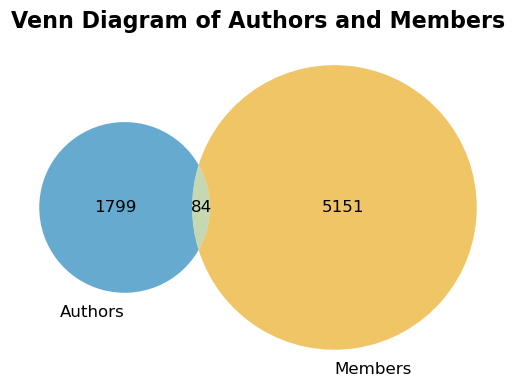

In [59]:
# Calculate the number of elements exclusive to each set and the intersection
authors_only = len(unique_authors) - len(intersection_names)
members_only = len(unique_members) - len(intersection_names)
common = len(intersection_names)

# Create the Venn diagram with customized colors and transparency
venn_diagram = venn2(subsets=(authors_only, members_only, common),
                     set_labels=('Authors', 'Members'),
                     set_colors=('#0072B2', '#E69F00'),
                     alpha=0.6)

# Customize the subset labels by setting font size and color
for subset_label in venn_diagram.subset_labels:
    if subset_label is not None:
        subset_label.set_fontsize(12)
        subset_label.set_color('black')

# Set the title of the diagram
plt.title("Venn Diagram of Authors and Members", fontsize=16, fontweight='bold')

# Save the figure
# AM in the file name refers to 'Author-Member'
plt.savefig('../data/processed/figure-images/01_venn_AM.png', dpi=300)

# Display the final Venn diagram
plt.show()

The following calculates the author-member intersection relative to the number of authors and members, respectively.

In [60]:
# Calculate the size of the intersection set
intersection_size = len(intersection_names)

# Calculate the percentages
percent_intersection_authors = (intersection_size / len(unique_authors)) * 100
percent_intersection_members = (intersection_size / len(unique_members)) * 100

# Print the results
print(f'Percent of the intersection relative to authors: {percent_intersection_authors:.2f}%')
print(f'Percent of the intersection relative to members: {percent_intersection_members:.2f}%')

Percent of the intersection relative to authors: 4.46%
Percent of the intersection relative to members: 1.60%
